In [1]:
import numpy as np
import cvxpy as cp
import osbdo as ob

In [2]:
import time
import random


np.random.seed(1001)
random.seed(1001)

# Problem description
section 4.1 in https://web.stanford.edu/~boyd/papers/os_bundle_distr_opt.html 

# Create parameters

In [3]:
ms = [20, 30, 40, 25, 35]
ns = [30, 40, 25, 35, 20]
params = ob.sc_params(ms, ns)

# Distributed solution

In [4]:
agents = ob.sc_agents(params)
g = ob.sc_coupling(params, agents)
prob = ob.Problem(agents = agents, g = g)

In [5]:
max_iter = 150
start_time = time.time()
x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=max_iter, memory=max_iter, print_freq=20)
print(f"elapsed time = {time.time() - start_time}")

k=0, rel_gap=inf, L=-2472.706641209428, U=3936.4781972599376, L0=-2472.706641209428
k=20, rel_gap=0.7709173491558531, L=-171.52239062951548, U=-96.85510772779736, L0=-171.52239062951548
rho=117.59802709653134


/var/folders/13/wyn3w3nx7ks002_qzk18rz7h0000gn/T/ipykernel_19239/1978256884.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  x_agent, x_global = prob.solve(rel_gap=10**(-5), abs_gap=10**(-5), max_iter=max_iter, memory=max_iter, print_freq=20)


k=40, rel_gap=0.13925722988855516, L=-121.81936080037053, U=-106.9287581455921, L0=-121.81936080037053
k=60, rel_gap=0.030373079329165737, L=-115.1878435916426, U=-111.79236521458495, L0=-115.1878435916426
k=80, rel_gap=0.009397878295106445, L=-113.25570705091604, U=-112.201253327585, L0=-113.25570705091604
k=100, rel_gap=0.002310830977669023, L=-112.76756744911154, U=-112.50758144468654, L0=-112.76756744911154
k=120, rel_gap=0.0008125922210692564, L=-112.63491268255507, U=-112.54346074182405, L0=-112.63491268255507
k=140, rel_gap=0.00030587661420156554, L=-112.59458408708042, U=-112.56015456810712, L0=-112.59458408708042
rel_gap=0.0002480611989704727, L=-112.5898934881534, U=-112.56197123061145
elapsed time = 148.01457118988037


# Centralized solution

In [6]:
h_cvx, x_cvx, prob_cvx = ob.cvx_supply_chain(params=params)

In [7]:
h_cvx, prob.upper_bnd[-1]

(-112.56431835964304, -112.56197123061145)

# Plot

i=59, omega_k=0.03126777239130244, omega_true=0.006857884952420722
i=80, omega_k=0.009397878295106445, omega_true=0.0032254007073365186


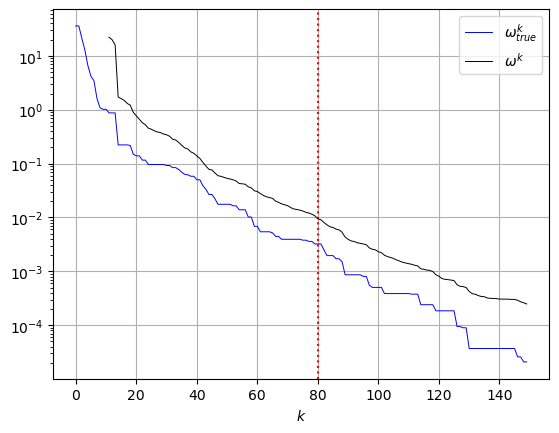

In [8]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx, file_name='sc_osbdo.pdf')